## Source 
https://github.com/corazzon/inflearn-new-year-event-2020

## 인프런 2020년 새해 다짐 이벤트 댓글 분석
* https://www.inflearn.com/pages/newyear-event-20200102
* 영상 튜토리얼 : [댓글 수백 수천개 분석하기?! [1/5] 이벤트 데이터 크롤링 feat. 인프런 새해 다짐 이벤트 - YouTube](https://www.youtube.com/watch?v=OUSwQk79H8I&list=PLaTc2c6yEwmohRzCxWQqJ7Z9aqc-sQ5gC)

## 기획자나 마케터가 되어 이벤트 댓글을 분석해 보자!
### 내가 만약 수백 수천개의 댓글을 다 읽어봐야 한다면?
### 댓글 속에 제품에 대한 관심을 빈도수로 추출해야 한다면?
* 쇼핑몰에서 제품 관련 이벤트 진행시 어떤 제품을 고객이 선호하는지 알고 싶다면?
* 고객 DB와 연계할 수 있다면 이벤트 혹은 마케팅 세그먼트로 활용해 볼 수도 있지 않을까?

### 향후 마케팅이나 전략을 어떻게 세워야 할까?

## 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline
# To display the visualizations clearly.
%config InlineBackend.figure_format = 'retina'

## 시각화를 위한 한글폰트 설정

In [2]:
# Window 한글폰트 설정
# plt.rc("font", family="Malgun Gothic")
# Mac 한글폰트 설정
plt.rc("font", family="AppleGothic")
plt.rc('axes', unicode_minus=False)

## 크롤링한 파일 로드하기

In [4]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [5]:
cd drive/My\ Drive/Colab\ Notebooks/voice_phishing/

/content/drive/My Drive/Colab Notebooks/voice_phishing


In [85]:
ls -l

total 115532
-rw------- 1 root root    59886 Nov  9  2020  asdf.png
-rw------- 1 root root   523988 Apr  1 10:36 'Bayesian Hyperparameter Optimization of Gradient Boosting Machine.ipynb'
drwx------ 2 root root     4096 Nov  4  2020  catboost_info/
-rw------- 1 root root   289178 Mar 15 13:08  code_plot.ipynb
drwx------ 2 root root     4096 Nov 20  2020  code-plots/
-rw------- 1 root root     1827 Nov 20  2020  code-plots.zip
-rw------- 1 root root    19125 Apr  1 10:36 'Copy of word_embeddings.ipynb'
drwx------ 2 root root     4096 Nov 11  2020  DL/
-rw------- 1 root root    19928 Feb 19  2021  firstname_preprocess.ipynb
drwx------ 2 root root     4096 Nov  9  2020  Fonts/
-rw------- 1 root root  2536056 Oct 12  2020  KorCCViD_v1.3.csv
-rw------- 1 root root  1504181 Nov 14  2020  KorCCViD_v1.3_fullcleansed.csv
-rw------- 1 root root  2450540 Nov  3  2020  KorCCViD_v1.3_halfcleansed.csv
-rw------- 1 root root 29066342 Apr 11 17:38  KorCCVi_v2.1.csv
-rw------- 1 root root 29067147 Apr 1

In [86]:
# Read in data and separate into training and testing sets from the mounted drive
# train = pd.read_csv('train_test_sets/train_KorCCVi_v2_fullcleansed.csv').drop(['Unnamed: 0'],axis=1).sample(frac=1.0)
# test = pd.read_csv('train_test_sets/test_KorCCVi_v2_fullcleansed.csv').drop(['Unnamed: 0'],axis=1).sample(frac=1.0)
# df = pd.concat([train, test])

#read the full scv file
df = pd.read_csv('KorCCVi_v2_fullcleansed.csv').sample(frac=1.0)
df.shape

(2927, 2)

In [87]:
# head 로 미리보기 합니다.
df.head()

,transcript,label
365,여행지 어디 중국 초등 학교 갔었 거든 처음 으로 근데 그때 어렸 니까 되게 신기 ...,0
2495,안녕 십니까 여기 시티 데려갑니다 안녕 세요 안녕 세요 여보세요 말씀 세요 대출 상...,1
2339,어버이날 특별히 부모 선물 한다기 보다 거의 주로 현금 으로 드리 선물 오래 어린이...,0
854,지금 키우 동물 나요 습니다 동물 사실 반려 동물 굉장히 거든요 어느 순간 부터 인...,0
1663,요즘 세대 기념일 케이크 10 넘어가 경우 다고 실제로 주변 기념일 비싼 케이크 으...,0


In [88]:
# tail 로 미리보기 합니다.
df.tail()

,transcript,label
915,대환 조건 인데 계시 조건 금리 사용 처럼 해서 저희 당신 기상 한지 빌려서 24 ...,1
2708,저희 에서 전반 내용 조사 결과 일단 경우 일정 으시 신부동 확실히 처리 본점 보이...,1
2681,우리 우리 겨울 잖아 그래 바꿔 볼라고 예전 동지 잖아 휴지 휴지 걸로 조금 추운 ...,0
88,혹시 계십니까 얼마 든지 얘기 해서 공장 에서 지금 대량 신용 카드 불법 배포 과정...,1
1007,부산 고등 검찰청 형사 김지웅 수사관 입니다 확인 사항 어서 연락 드렸 지금 통화 ...,1


## Seperate type of text.

In [89]:
df = df.groupby('label').get_group(0)
# df = df.groupby('label').get_group(1)

In [90]:
# print(voicephishing_text)
# print(normal_text)

In [91]:
# # drop unwantyed column
df.drop(['label'], axis=1, inplace=True)
print(df.shape)
print(df.head)

(2232, 1)
<bound method NDFrame.head of                                              transcript
365   여행지 어디 중국 초등 학교 갔었 거든 처음 으로 근데 그때 어렸 니까 되게 신기 ...
2339  어버이날 특별히 부모 선물 한다기 보다 거의 주로 현금 으로 드리 선물 오래 어린이...
854   지금 키우 동물 나요 습니다 동물 사실 반려 동물 굉장히 거든요 어느 순간 부터 인...
1663  요즘 세대 기념일 케이크 10 넘어가 경우 다고 실제로 주변 기념일 비싼 케이크 으...
1549  연예인 으세요 방탄소년단 인데요 2011 데뷔 그때 부터 돼서 2013 데뷔 무대 ...
...                                                 ...
285   최근 기사 니까 족발 사장 어쩌다 망치 휘둘러 살인 미수범 기사 너무 충격 어요 기...
1276  자이르 보우 소라 보우 소나 라는 대통령 치러진 브라질 대선 에서 승리 대통령 잖아...
2821  요즘 예능 프로그램 에서 제일 관심 프로그램 뭔가요 요즘 드라마 아이 아니 해서 예...
1346  예년 으면 여름 휴가 다녀오 추석 연휴 휴가 다녀왔 텐데 올해 코로나 때문 꼼짝 없...
2681  우리 우리 겨울 잖아 그래 바꿔 볼라고 예전 동지 잖아 휴지 휴지 걸로 조금 추운 ...

[2232 rows x 1 columns]>


## data preprocessing


### 네트워크 오류 등으로 발생한 중복 입력 값을 제거
## Eliminates duplicate input values ​​caused by network errors, etc.

> Indented block


* 빈도 수 중복을 방지하기 위해 / To avoid duplication of frequency numbers


In [92]:
# drop_duplicates 를 통해 중복을 제거합니다. 이때 마지막 글을 남깁니다.
print(df.shape)
df = df.drop_duplicates(["transcript"], keep="last")
print(df.shape)

(2232, 1)
(2232, 1)


### 원본은 따로 보존 / Keep the original separately

In [93]:
# 전처리 전에 원본을 보존하기 위해 origin_text 라는 컬럼에 복사해 둡니다.
# Before pre-processing, copy the original to a column called origin_text.
df["origin_transcript"] = df["transcript"]
df.head()

,transcript,origin_transcript
365,여행지 어디 중국 초등 학교 갔었 거든 처음 으로 근데 그때 어렸 니까 되게 신기 ...,여행지 어디 중국 초등 학교 갔었 거든 처음 으로 근데 그때 어렸 니까 되게 신기 ...
2339,어버이날 특별히 부모 선물 한다기 보다 거의 주로 현금 으로 드리 선물 오래 어린이...,어버이날 특별히 부모 선물 한다기 보다 거의 주로 현금 으로 드리 선물 오래 어린이...
854,지금 키우 동물 나요 습니다 동물 사실 반려 동물 굉장히 거든요 어느 순간 부터 인...,지금 키우 동물 나요 습니다 동물 사실 반려 동물 굉장히 거든요 어느 순간 부터 인...
1663,요즘 세대 기념일 케이크 10 넘어가 경우 다고 실제로 주변 기념일 비싼 케이크 으...,요즘 세대 기념일 케이크 10 넘어가 경우 다고 실제로 주변 기념일 비싼 케이크 으...
1549,연예인 으세요 방탄소년단 인데요 2011 데뷔 그때 부터 돼서 2013 데뷔 무대 ...,연예인 으세요 방탄소년단 인데요 2011 데뷔 그때 부터 돼서 2013 데뷔 무대 ...


## 띄어 쓰기를 제거한 텍스트에서 키워드 추출 Extract keywords from text with spaces removed
* TIOBE 프로그래밍 언어 순위 : [index | TIOBE - The Software Quality Company](https://www.tiobe.com/tiobe-index/?fbclid=IwAR34dJfgDHq2DK0C6X3g8IsUno2NhOiikMyxT6fw9SoyujFhy5FPvQogMoA)

In [94]:
# 특정 키워드가 들어가는 댓글을 찾습니다.
search_keyword = ['대출빙자형', '정부 정책자금', '대출', '승인', '대출 승인', '저금리', '돈',
                  '채무한도', '초과', '채무한도 초과', '채무', '상환', '채무 상환', '첨단범죄수사부',
                  '당일 수령', '서울중앙지검', '서울중앙지방검찰청', '검찰청', '통장', '금융', '범죄',
                  '서울지방경찰청', '대포통장', '신용등급', '납치', '예금','은행', '신용', '카드', '고객',
                  '보내', '보이스 피싱', '피싱']

# for 문을 통해 해당 키워드가 있는지 여부를 True, False값으로 표시하도록 합니다.
# 키워드에 따라 컬럼을 새로 만듭니다.
for keyword in search_keyword:
    df[keyword] = df["transcript"].str.contains(keyword)

In [95]:
# 미리보기 합니다.
df.head()

,transcript,origin_transcript,대출빙자형,정부 정책자금,대출,승인,대출 승인,저금리,돈,채무한도,...,신용등급,납치,예금,은행,신용,카드,고객,보내,보이스 피싱,피싱
365,여행지 어디 중국 초등 학교 갔었 거든 처음 으로 근데 그때 어렸 니까 되게 신기 ...,여행지 어디 중국 초등 학교 갔었 거든 처음 으로 근데 그때 어렸 니까 되게 신기 ...,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2339,어버이날 특별히 부모 선물 한다기 보다 거의 주로 현금 으로 드리 선물 오래 어린이...,어버이날 특별히 부모 선물 한다기 보다 거의 주로 현금 으로 드리 선물 오래 어린이...,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
854,지금 키우 동물 나요 습니다 동물 사실 반려 동물 굉장히 거든요 어느 순간 부터 인...,지금 키우 동물 나요 습니다 동물 사실 반려 동물 굉장히 거든요 어느 순간 부터 인...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1663,요즘 세대 기념일 케이크 10 넘어가 경우 다고 실제로 주변 기념일 비싼 케이크 으...,요즘 세대 기념일 케이크 10 넘어가 경우 다고 실제로 주변 기념일 비싼 케이크 으...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1549,연예인 으세요 방탄소년단 인데요 2011 데뷔 그때 부터 돼서 2013 데뷔 무대 ...,연예인 으세요 방탄소년단 인데요 2011 데뷔 그때 부터 돼서 2013 데뷔 무대 ...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [96]:
# 결과를 모두 더하면 해당 키워드의 등장 빈도수를 카운트 할 수 있습니다.
# search_keyword 컬럼만 가져와서 빈도수를 sum으로 더합니다.
df[search_keyword].sum().sort_values(ascending=False)

보내           579
돈            361
범죄            80
카드            77
고객            66
통장            28
대출            18
금융            15
초과            10
은행             6
납치             5
신용             5
예금             1
보이스 피싱         1
검찰청            1
승인             1
피싱             1
신용등급           0
대포통장           0
서울지방경찰청        0
대출빙자형          0
정부 정책자금        0
서울중앙지검         0
당일 수령          0
첨단범죄수사부        0
채무 상환          0
상환             0
채무             0
채무한도 초과        0
채무한도           0
저금리            0
대출 승인          0
서울중앙지방검찰청      0
dtype: int64

## 판다스 단어가 들어가는 텍스트만 찾기
* 이미 str.contains 를 통해 판다스가 들어가는 텍스트에 대해 컬럼을 만들어 놨습니다. 이 값이  True 라면 판다스 강좌 입니다.

In [97]:
# 대포통장 라는 텍스트가 들어가는 내용만 찾습니다.
df.loc[df["대포통장"] == True, "transcript"]

Series([], Name: transcript, dtype: object)

## 빈도수 계산을 위한 텍스트 데이터 벡터화
* BOW 단어 가방에 단어를 토큰화 해서 담아줌

In [98]:
# 사이킷런의 CountVectorizer 를 통해 벡터화 합니다.
# vectorizer 라는 변수에 CountVectorizer 를 담습니다.
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋습니다. 
                             ngram_range=(2, 6), # 3,6  BOW의 단위 갯수의 범위를 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수
                            )
vectorizer

CountVectorizer(max_features=2000, min_df=2, ngram_range=(2, 6))

In [99]:
feature_vector = vectorizer.fit_transform(df['transcript'])
feature_vector.shape

(2232, 2000)

In [100]:
# vectorizer 에서 get_feature_names 를 추출합니다.
vocab = vectorizer.get_feature_names_out()
print(len(vocab))
vocab[:10]

2000


array(['10 정도', '갑자기 생각', '갔었 거든요', '강아지 고양이', '강아지 키우', '같이 같이', '같이 그런',
       '같이 니까', '같이 다니', '같이 면서'], dtype=object)

In [101]:
# 각 리뷰마다 등장하는 단어에 빈도수가 표현됩니다. 0 은 등장하지 않음을 의미합니다.
pd.DataFrame(feature_vector[:10].toarray(), columns=vocab).head()

,10 정도,갑자기 생각,갔었 거든요,강아지 고양이,강아지 키우,같이 같이,같이 그런,같이 니까,같이 다니,같이 면서,...,힘드 니까,힘든 아요,힘들 다고,힘들 더라고,힘들 더라고요,힘들 아요,힘들 어서,힘들 어요,힘들 었었,힘들 지만
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [102]:
# 위에서 구한 단어벡터를 더하면 단어가 전체에서 등장하는 횟수를 알 수 있습니다.
# 벡터화 된 피처를 확인해 봄
# Bag of words 에 몇 개의 단어가 들어있는지 확인
dist = np.sum(feature_vector, axis=0)
    
df_freq = pd.DataFrame(dist, columns=vocab)
df_freq

,10 정도,갑자기 생각,갔었 거든요,강아지 고양이,강아지 키우,같이 같이,같이 그런,같이 니까,같이 다니,같이 면서,...,힘드 니까,힘든 아요,힘들 다고,힘들 더라고,힘들 더라고요,힘들 아요,힘들 어서,힘들 어요,힘들 었었,힘들 지만
0,70,104,91,142,276,89,79,70,82,83,...,76,72,149,69,158,114,180,162,68,155


In [103]:
# 행과 열의 축을 T로 바꿔주고 빈도수로 정렬합니다.
# Change the axis of rows and columns to T and sort them by frequency.
df_freq.T.sort_values(by=0, ascending=False).head(30)

,0
다고 생각,4067
라고 생각,3420
더라고요 그래서,2620
우리 나라,2470
거든요 그래서,1944
어요 그래서,1917
라는 생각,1856
그런 생각,1578
생각 합니다,1532
어떻게 생각,1525


In [104]:
# 전처리가 다 되었다면 다른 팀 또는 담당자에게 전달하기 위해  csv 형태로 저장합니다.
df_freq.to_csv("normal_text-freq-top20.csv")
# df_freq.to_csv("vishing_text-freq-top20.csv")

In [105]:
# ["transcript", "freq"] 라는 컬럼명을 주어 위에서 만든 데이터프레임을 변환합니다.
df_freq_T = df_freq.T.reset_index()
df_freq_T.columns = ["transcript", "freq"]
df_freq_T.head()

,transcript,freq
0,10 정도,70
1,갑자기 생각,104
2,갔었 거든요,91
3,강아지 고양이,142
4,강아지 키우,276


In [106]:
# 강의명을 토큰 3개로 중복제거하기 위해, 강좌명에서 지식공유자의 이름을 빈문자열로 변경합니다.
# 강의명을 lambda 식을 사용해서 x.split() 으로 나누고 [:4] 앞에서 4개까지만 텍스트를 가져오고 다시 join으로 합쳐줍니다. 
# 중복된 텍스트를 구분해서 보기 위함입니다.
df_freq_T["course_find"] = df_freq_T["transcript"].str.replace("개인", "")
df_freq_T["course_find"] = df_freq_T["course_find"].apply(lambda x : " ". join(x.split()[:4]))
df_freq_T.sort_values(["course_find", "freq"], ascending=False).head(10)

,transcript,freq,course_find
1999,힘들 지만,155,힘들 지만
1998,힘들 었었,68,힘들 었었
1997,힘들 어요,162,힘들 어요
1996,힘들 어서,180,힘들 어서
1995,힘들 아요,114,힘들 아요
1994,힘들 더라고요,158,힘들 더라고요
1993,힘들 더라고,69,힘들 더라고
1992,힘들 다고,149,힘들 다고
1991,힘든 아요,72,힘든 아요
1990,힘드 니까,76,힘드 니까


In [107]:
# 3개의 ngram과 빈도수로 역순 정렬을 하게 되면 빈도수가 높고, ngram수가 많은 순으로 정렬이 됨 
# 여기에서 drop_duplicates로 첫 번째 강좌를 남기고 나머지 중복을 삭제 합니다.
print(df_freq_T.shape)
df_course = df_freq_T.drop_duplicates(["course_find", "freq"], keep="first")
print(df_course.shape)

(2000, 3)
(2000, 3)


In [108]:
# 빈도수로 정렬을 하고 어떤 강좌가 댓글에서 가장 많이 언급되었는지 봅니다.
# Sort by frequency and see which word were mentioned most frequently in the transcript.
df_course = df_course.sort_values(by="freq", ascending=False)
df_course.head(20)

,transcript,freq,course_find
593,다고 생각,4067,다고 생각
749,라고 생각,3420,라고 생각
664,더라고요 그래서,2620,더라고요 그래서
1492,우리 나라,2470,우리 나라
40,거든요 그래서,1944,거든요 그래서
1346,어요 그래서,1917,어요 그래서
770,라는 생각,1856,라는 생각
320,그런 생각,1578,그런 생각
1120,생각 합니다,1532,생각 합니다
1308,어떻게 생각,1525,어떻게 생각


## TF-IDF 로 가중치를 주어 벡터화
### TfidfTransformer()
* norm='l2' 각 문서의 피처 벡터를 어떻게 벡터 정규화 할지 정합니다.
    - L2 : 벡터의 각 원소의 제곱의 합이 1이 되도록 만드는 것이고 기본 값(유클리디안거리)
    - L1 : 벡터의 각 원소의 절댓값의 합이 1이 되도록 크기를 조절(맨하탄거리)
* smooth_idf=False
    - 피처를 만들 때 0으로 나오는 항목에 대해 작은 값을 더해서(스무딩을 해서) 피처를 만들지 아니면 그냥 생성할지를 결정
* sublinear_tf=False
* use_idf=True
    - TF-IDF를 사용해 피처를 만들 것인지 아니면 단어 빈도 자체를 사용할 것인지 여부

In [109]:
# TfidfTransformer 를 불러와서 가중치를 주어 벡터화 합니다.
# transformer 라는 변수로 저장하고 재사용합니다.
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(smooth_idf=False)

In [110]:
# fit_transform 으로 가중치를 적용하고 결과를 feature_tfidf 로 받습니다.
feature_tfidf = transformer.fit_transform(feature_vector)
feature_tfidf.shape

(2232, 2000)

In [111]:
# 각 row에서 전체 단어가방에 있는 어휘에서 등장하는 단어에 대한 one-hot-vector에 TF-IDF 가중치 반영한 결과를 봅니다.
# feature_tfidf.toarray() 로 배열로 만들고  데이터 프레임을 만들어 tfidf_freq 라는 변수에 할당해서 봅니다.
tfidf_freq = pd.DataFrame(feature_tfidf.toarray(), columns=vocab)
tfidf_freq.head() 

,10 정도,갑자기 생각,갔었 거든요,강아지 고양이,강아지 키우,같이 같이,같이 그런,같이 니까,같이 다니,같이 면서,...,힘드 니까,힘든 아요,힘들 다고,힘들 더라고,힘들 더라고요,힘들 아요,힘들 어서,힘들 어요,힘들 었었,힘들 지만
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.211188,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.060486,0.0,0.0,0.0,0.0,0.0


In [112]:
# tfidf_freq를 sum 으로 가중치를 다 더해줍니다.
df_tfidf = pd.DataFrame(tfidf_freq.sum())
df_tfidf_top = df_tfidf.sort_values(by=0, ascending=False)
df_tfidf_top.head(30)

,0
다고 생각,99.614577
우리 나라,96.194812
라고 생각,84.831902
더라고요 그래서,77.534108
생각 합니다,63.101331
거든요 그래서,62.376151
라는 생각,60.695429
어요 그래서,59.745276
어떻게 생각,54.817962
그런 생각,51.116036


In [113]:
# save the word frequency
df_tfidf_top.to_csv("nor_text_tfidf_freq-word-top20.csv")
# df_tfidf_top.to_csv("vishing_text_tfidf_freq-word-top20.csv")

In [114]:
ls -l

total 114398
-rw------- 1 root root    59886 Nov  9  2020  asdf.png
-rw------- 1 root root   523988 Apr  1 10:36 'Bayesian Hyperparameter Optimization of Gradient Boosting Machine.ipynb'
drwx------ 2 root root     4096 Nov  4  2020  catboost_info/
-rw------- 1 root root   289178 Mar 15 13:08  code_plot.ipynb
drwx------ 2 root root     4096 Nov 20  2020  code-plots/
-rw------- 1 root root     1827 Nov 20  2020  code-plots.zip
-rw------- 1 root root    19125 Apr  1 10:36 'Copy of word_embeddings.ipynb'
drwx------ 2 root root     4096 Nov 11  2020  DL/
-rw------- 1 root root    19928 Feb 19  2021  firstname_preprocess.ipynb
drwx------ 2 root root     4096 Nov  9  2020  Fonts/
-rw------- 1 root root  2536056 Oct 12  2020  KorCCViD_v1.3.csv
-rw------- 1 root root  1504181 Nov 14  2020  KorCCViD_v1.3_fullcleansed.csv
-rw------- 1 root root  2450540 Nov  3  2020  KorCCViD_v1.3_halfcleansed.csv
-rw------- 1 root root 29066342 Apr 11 17:38  KorCCVi_v2.1.csv
-rw------- 1 root root 29067147 Apr 1

In [115]:
# 중간에 생략되는 단어를 자세히 보고자 할 때
for t in df_tfidf_top.index[:30]:
    print(t)

다고 생각
우리 나라
라고 생각
더라고요 그래서
생각 합니다
거든요 그래서
라는 생각
어요 그래서
어떻게 생각
그런 생각
거든 근데
아요 그래서
거든요 근데
어요 근데
조금 많이
반려 동물
그런 부분
그러 니까
더라고 그래서
생각 해요
다는 생각
남자 친구
어느 정도
생각 어요
초등 학교
코로나 때문
나라 에서
되게 많이
그래서 그런
습니다 혹시


## 군집화 
* 실루엣 분석추가 https://www.kaggle.com/fabiendaniel/customer-segmentation
### KMeans

In [116]:
from sklearn.cluster import KMeans
from tqdm import trange
inertia = []

start = 30
end = 70

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
# trange 를 통해 시작과 끝 값을 지정해 주면 진행 정도를 알 수 있습니다.
# 학습을 할 때는 feature_tfidf 값을 사용합니다.
# cls.inertia_ 값을 inertia 리스트에 저장합니다.
for i in trange(start, end):
    cls = KMeans(n_clusters=i, random_state=42)
    cls.fit(feature_tfidf)
    inertia.append(cls.inertia_)

100%|██████████| 40/40 [02:11<00:00,  3.28s/it]


Text(0.5, 1.0, 'KMeans 클러스터 수 비교')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47084 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_

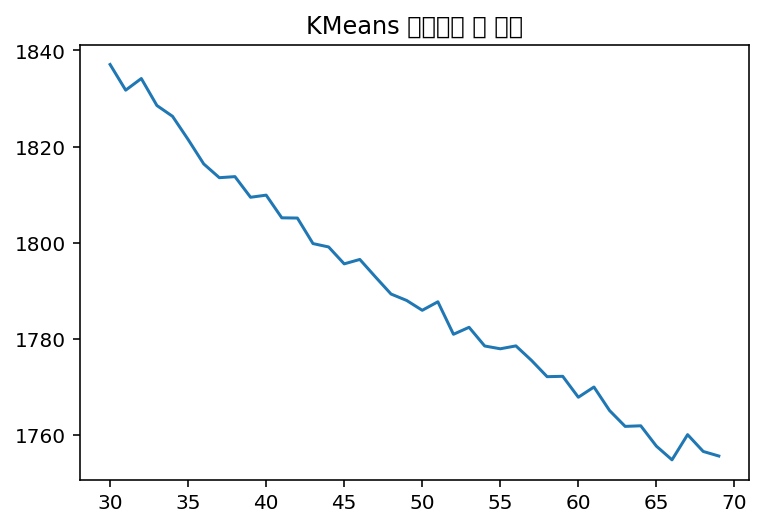

In [117]:
# 위에서 구한 값을 시각화 합니다.
# x축에는 클러스터의 수를 y축에는 inertia 값을 넣어 그립니다.

plt.plot(range(start, end), inertia)
plt.title("KMeans 클러스터 수 비교")

* 적정한 클러스터 갯수를 넣어 군집화 합니다.

In [118]:
# n_clusters 에 적절한 값을 넣어줍니다.
# fit.predict 를 하고 결과를 cluster 라는 새로운 컬럼에 담습니다.
n_clusters = 15
cls = KMeans(n_clusters=n_clusters, random_state=42)
cls.fit(feature_tfidf)
prediction = cls.predict(feature_tfidf)
df["cluster"] = prediction

In [119]:
# 클러스터 센터
cc = cls.cluster_centers_

In [120]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

X_tsne = tsne.fit_transform(feature_tfidf)
X_tsne.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2232, 2)

In [121]:
df2d = pd.DataFrame(X_tsne, columns=['x', 'y'])
df2d.shape

(2232, 2)

In [122]:
df2d["cluster"] = prediction
df2d.head()

,x,y,cluster
0,34.278751,-14.873563,13
1,-20.269279,34.251362,6
2,1.289250,62.098206,5
3,-0.467554,8.621946,14
4,2.415093,-35.237270,8


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


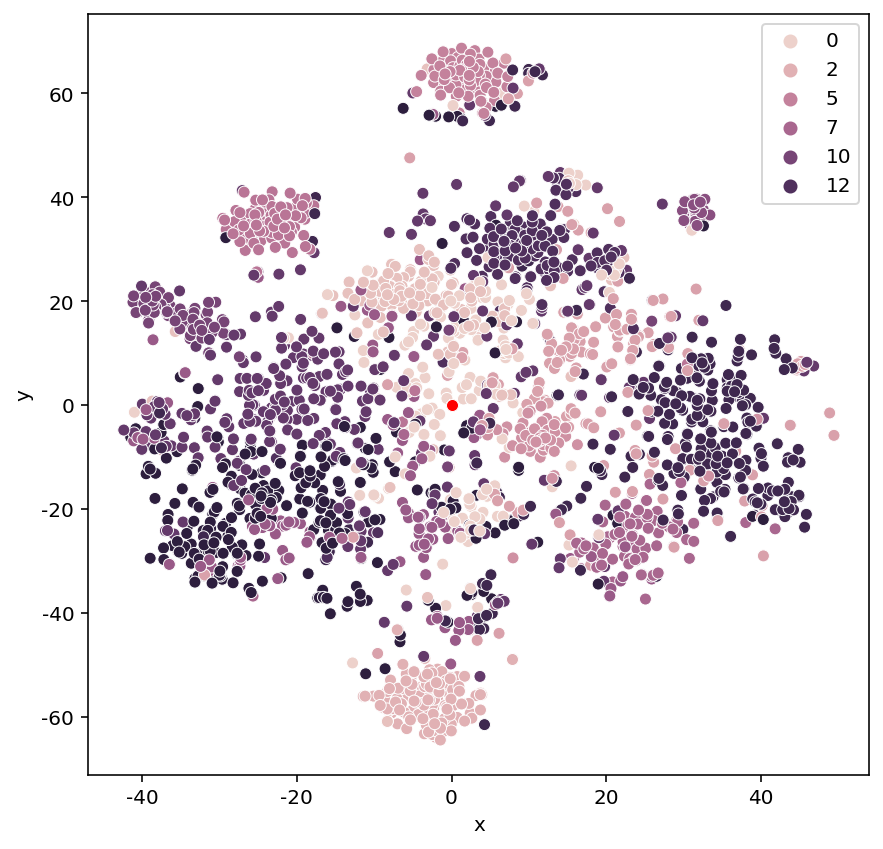

In [123]:
import seaborn as sns
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df2d, x="x", y="y", hue="cluster")
sns.scatterplot(cc[:, 0], cc[:, 1],  color='red')

In [124]:
# df["cluster"] 의 빈도수를 value_counts로 세어봅니다.
df["cluster"].value_counts().head(10)

11    331
14    294
13    291
0     180
3     173
12    146
8     141
1     127
2     123
6      94
Name: cluster, dtype: int64

### MiniBatchKMeans
* [Comparison of the K-Means and MiniBatchKMeans clustering algorithms — scikit-learn 0.22.1 documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html)

In [125]:
# batch_size 를 쓸 수 있는 MiniBatchKMeans 로 군집화
from sklearn.cluster import MiniBatchKMeans
b_inertia = []

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
# trange 를 통해 시작과 끝 값을 지정해 주면 진행 정도를 알 수 있습니다.
# b_inertia 리스트에 cls.inertia_ 값을 넣어줍니다.
for i in trange(start, end):
    cls = MiniBatchKMeans(n_clusters=i, random_state=42)
    cls.fit(feature_tfidf)
    b_inertia.append(cls.inertia_)

100%|██████████| 40/40 [00:46<00:00,  1.16s/it]


Text(0.5, 1.0, 'MiniBatchKMeans 클러스터 수 비교')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47084 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_

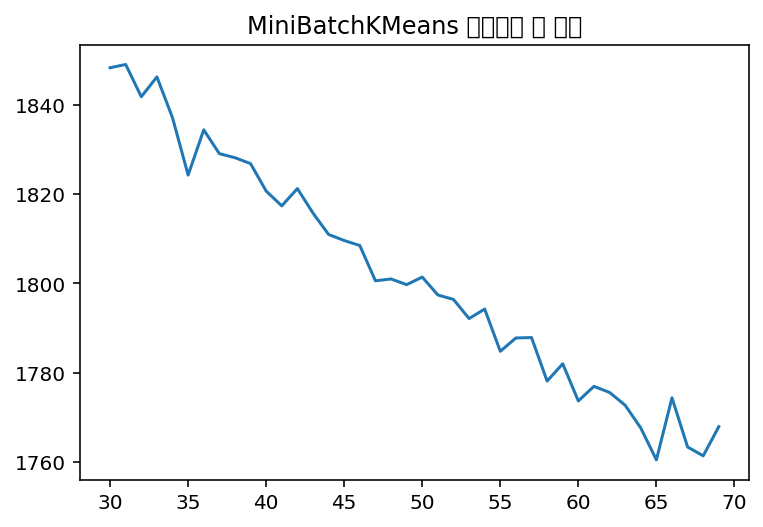

In [126]:
# 위에서 구한 값을 시각화 합니다.
# x축에는 클러스터의 수를 y축에는 b_inertia 값을 넣어 그립니다.
plt.plot(range(start, end), b_inertia)
plt.title("MiniBatchKMeans 클러스터 수 비교")

In [127]:
# MiniBatchKMeans 를 통해 학습을 시킵니다.
# 결과를 bcluster 라는 변수에 저장합니다.
cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
cls.fit(feature_tfidf)
prediction = cls.predict(feature_tfidf)
df["bcluster"] = prediction

In [128]:
# bcluster의 빈도수를 구합니다.
df["bcluster"].value_counts().head(10)

2     455
11    230
1     209
3     205
12    185
14    151
10    128
5     113
8     102
6      96
Name: bcluster, dtype: int64

In [129]:
# 어떤 강좌명이 있는지 특정 클러스터의 값을 봅니다.  
df.loc[df["bcluster"] == 10, "transcript"].value_counts().head(1)

요즘 결혼 남자 그렇 여자 그렇 굉장히 추세 인데 남자 주변 면은 조금 걱정 경제력 많이 중요 지금 세대 하나 자식 아들 결혼 사랑 그래 중요 생각 연상 으로 스무 사람 면은 어떨까 아들 나이 여자 온다 글쎄 그거 자식 어서 모르 지마는 굳이 지금 시대 세대 에서 부모 굳이 반대 필요 생각 많이 더라 굳이 자식 결혼 싱글 라면 굳이 결혼 시켜야 필요 필요 다고 생각 거기 부모 입장 에서 어떤 마음 인지 모르 니까 친구 어떤데 경우 아들 인데 그렇게 힘들 면은 정도 사람 좋아하 아니 면은 사생결단 말릴 생각 생각 연상 커트라인 일고여덟 우리 아들 일고여덟 연상 면은 정도 요즘 연예인 여서 일곱 일고여덟 정도 주변 간혹 면은 커플 거꾸로 남자 아니 여자 커플 어서 그래서 질문 한번 사생결단 해서 도시락 당기 면서 말릴 사랑 결혼 어떻게 생각 지금 잔데 사랑 경제력 남자 프러포즈 한다면은 사랑 어도 결혼 다고 생각 사람 라서 경제력 면은 경제력 면서 사랑 생긴다고 생각 사람 라서 물론 사람 상대 따라서 다르 지마는 사람 성격 인격 성향 따라서 다르 지마는 다고 사람 한테 아무리 사랑 려고 해도 생기 근데 진짜 결혼 연애 사람 주위 에서 면은 정말 대단 라는 생각 많이 지마는 사랑 순위 사랑 아니 라고 생각 사람 라서 경제력 면은 사랑 거기 플러스 따라온다는 사람 라서 요즘 커플 남사 여사 미혼자 기혼자 지금 기혼 잔데 남자 친구 사귄다 거꾸로 기혼자 사친 사귄다는 대한 소신 친구 관점 그것 자기 본인 능력 나쁘 생각 능력 물론 지만 불륜 지마는 사람 나가 만나 면은 사랑 생기 버리 면은 버릴 생길 그러 면은 버리 지마는 글면 로맨스 불륜 라는 듯이 우리 니까 그냥 받아들이 밖에 에서 그거 질투 니까 다가 본인 자기 자리 돌아가 돌아가 사람 더라고 간혹 사람 조금 별로 주위 나가 연애 사람 친구 항상 지킬 지키 면서 에서 라고 그리 지키 친구 더라고 결국 버리 나오 친구 더라고 그거 쪼금 바보 아닌가 그랬 해선 지만은 해버렸 자기 자제력 니까 어쩔 결혼 생활 20 찬

In [130]:
# bcluster, cluster, course 값을 미리보기 합니다.
df.loc[df["bcluster"] == 21, ["bcluster", "cluster", "transcript"]]

,bcluster,cluster,transcript


In [131]:
df.loc[df["bcluster"] == 2, ["bcluster", "cluster", "origin_transcript", "transcript"]].tail(10)

,bcluster,cluster,origin_transcript,transcript
2542,2,14,혹시 형제 자매 으세요 남동생 나이 보다 아래 스물 다섯 에요 대학 다니 사실 예전...,혹시 형제 자매 으세요 남동생 나이 보다 아래 스물 다섯 에요 대학 다니 사실 예전...
1084,2,8,선생 요즘 건강 보조 식품 광고 정말 많이 나와요 인터넷 어려울 정도 정말 많이 나...,선생 요즘 건강 보조 식품 광고 정말 많이 나와요 인터넷 어려울 정도 정말 많이 나...
1003,2,14,혹시 아르바이트 에서 조금 재미있 아르바이트 조금 특색 아르바이트 혹시 으세요 성인...,혹시 아르바이트 에서 조금 재미있 아르바이트 조금 특색 아르바이트 혹시 으세요 성인...
1700,2,11,2020 벌써 마지막 입니다 벌써 2020 개월 지나갔 혹시 올해 면서 누구 새해 ...,2020 벌써 마지막 입니다 벌써 2020 개월 지나갔 혹시 올해 면서 누구 새해 ...
2048,2,8,요즘 따라 유독 날씨 너무 변화무쌍 다고 생각 며칠 추웠 다가 어느새 갑자기 여름 ...,요즘 따라 유독 날씨 너무 변화무쌍 다고 생각 며칠 추웠 다가 어느새 갑자기 여름 ...
1382,2,14,혹시 계절 여름 겨울 어떤 계절 세요 계절 에서 여름 여름 조금 겨울 되게 프릴 프...,혹시 계절 여름 겨울 어떤 계절 세요 계절 에서 여름 여름 조금 겨울 되게 프릴 프...
2734,2,14,여행 어디 어디 어요 여행 많이 부산 제주도 대만 그리고 내일 면서 여러 습니다 제...,여행 어디 어디 어요 여행 많이 부산 제주도 대만 그리고 내일 면서 여러 습니다 제...
1609,2,11,짜리 사내 아이 키우 아빠 입니다 저희 부모 께서 대전 아들 그러니까 할머니 아들 ...,짜리 사내 아이 키우 아빠 입니다 저희 부모 께서 대전 아들 그러니까 할머니 아들 ...
444,2,7,학교 다닐 급식 정말 거든요 저희 학교 급식 너무 어서 매년 급식 만들 영양사 선생...,학교 다닐 급식 정말 거든요 저희 학교 급식 너무 어서 매년 급식 만들 영양사 선생...
1346,2,8,예년 으면 여름 휴가 다녀오 추석 연휴 휴가 다녀왔 텐데 올해 코로나 때문 꼼짝 없...,예년 으면 여름 휴가 다녀오 추석 연휴 휴가 다녀왔 텐데 올해 코로나 때문 꼼짝 없...


### 클러스터 예측 정확도 확인하기

In [132]:
# n_clusters 위에서 정의한 클러스터 수를 사용
feature_array = feature_vector.toarray()
# 예측한 클러스터의 유니크 값
labels = np.unique(prediction)
df_cluster_score = []
df_cluster = []
for label in labels:
    id_temp = np.where(prediction==label) # 예측한 값이 클러스터 번호와 매치 되는 것을 가져옴
    x_means = np.mean(feature_array[id_temp], axis = 0) # 클러스터의 평균 값을 구함
    sorted_means = np.argsort(x_means)[::-1][:n_clusters] # 값을 역순으로 정렬해서 클러스터 수 만큼 가져옴
    features = vectorizer.get_feature_names_out()
    best_features = [(features[i], x_means[i]) for i in sorted_means] 
    # 클러스터별 전체 스코어
    df_score = pd.DataFrame(best_features, columns = ['features', 'score'])
    df_cluster_score.append(df_score)
    # 클러스터 대표 키워드
    df_cluster.append(best_features[0])

In [133]:
# 개별 클러스터에서 점수가 가장 높은 단어를 추출 아래 점수가 클수록 예측 정확도가 높음
# MiniBatchKMeans 로 예측한 값 기준
pd.DataFrame(df_cluster, columns = ['features', 'score']).sort_values(by=["features", "score"], ascending=False)

,features,score
4,한테 선물,2.966667
14,우리 나라,7.509934
5,우리 나라,3.477876
12,생각 합니다,4.805405
6,비티 아이,3.260417
7,반려 동물,10.230769
3,라고 생각,1.995122
2,더라고요 그래서,2.553846
1,더라고 그래서,1.181818
10,다고 생각,3.859375


In [134]:
# score 정확도가 1이 나온 클러스터를 찾아봄 - 같은 강좌끼리 묶였는지 확인 함
df.loc[df["bcluster"] == 21, ["bcluster", "cluster", "origin_transcript", "transcript"]]

,bcluster,cluster,origin_transcript,transcript


## WordCloud
* [amueller/word_cloud: A little word cloud generator in Python](https://github.com/amueller/word_cloud)
* 설치 방법 : [Wordcloud :: Anaconda Cloud](https://anaconda.org/conda-forge/wordcloud)

In [135]:
!pip install wordcloud

In [136]:
# 불용어 - 자주 등장하지만 의미가 크지 않아 제외하고 싶은 텍스트
stopwords = ["어요", "아니", "입니다", "에서", "니까", "으로",
             "근데", "습니다", "습니까", "저희", "합니다", "하고", "싶어요", 
             "있는", "있습니다", "싶습니다", "그냥", "고요", "에요", "예요", "으시",
            "그래서"]
# # 불용어를 제거하지 않고 그리려면 아래 주석을 풀어서 stopword 변수에 덮어쓰기를 합니다.
# stopwords = []

# stopwords = pd.read_csv('ranks.nlstopwordskorean.txt', header=None)

In [137]:
# # create the pandas series of all the names to matche
# stopwords[0] = stopwords[0].astype(str)
# stopwords = stopwords[0].tolist()

In [138]:
# displayWordCloud 라는 함수를 만들어 재사용합니다.
from wordcloud import WordCloud

def displayWordCloud(data = None, backgroundcolor = 'white', width=1280, height=768):
    wordcloud = WordCloud(
                        font_path = 'Fonts/NanumBarunGothic.ttf', 
                        stopwords = stopwords, 
                        background_color = backgroundcolor, 
                        width = width, height = height, 
                        random_state=42).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

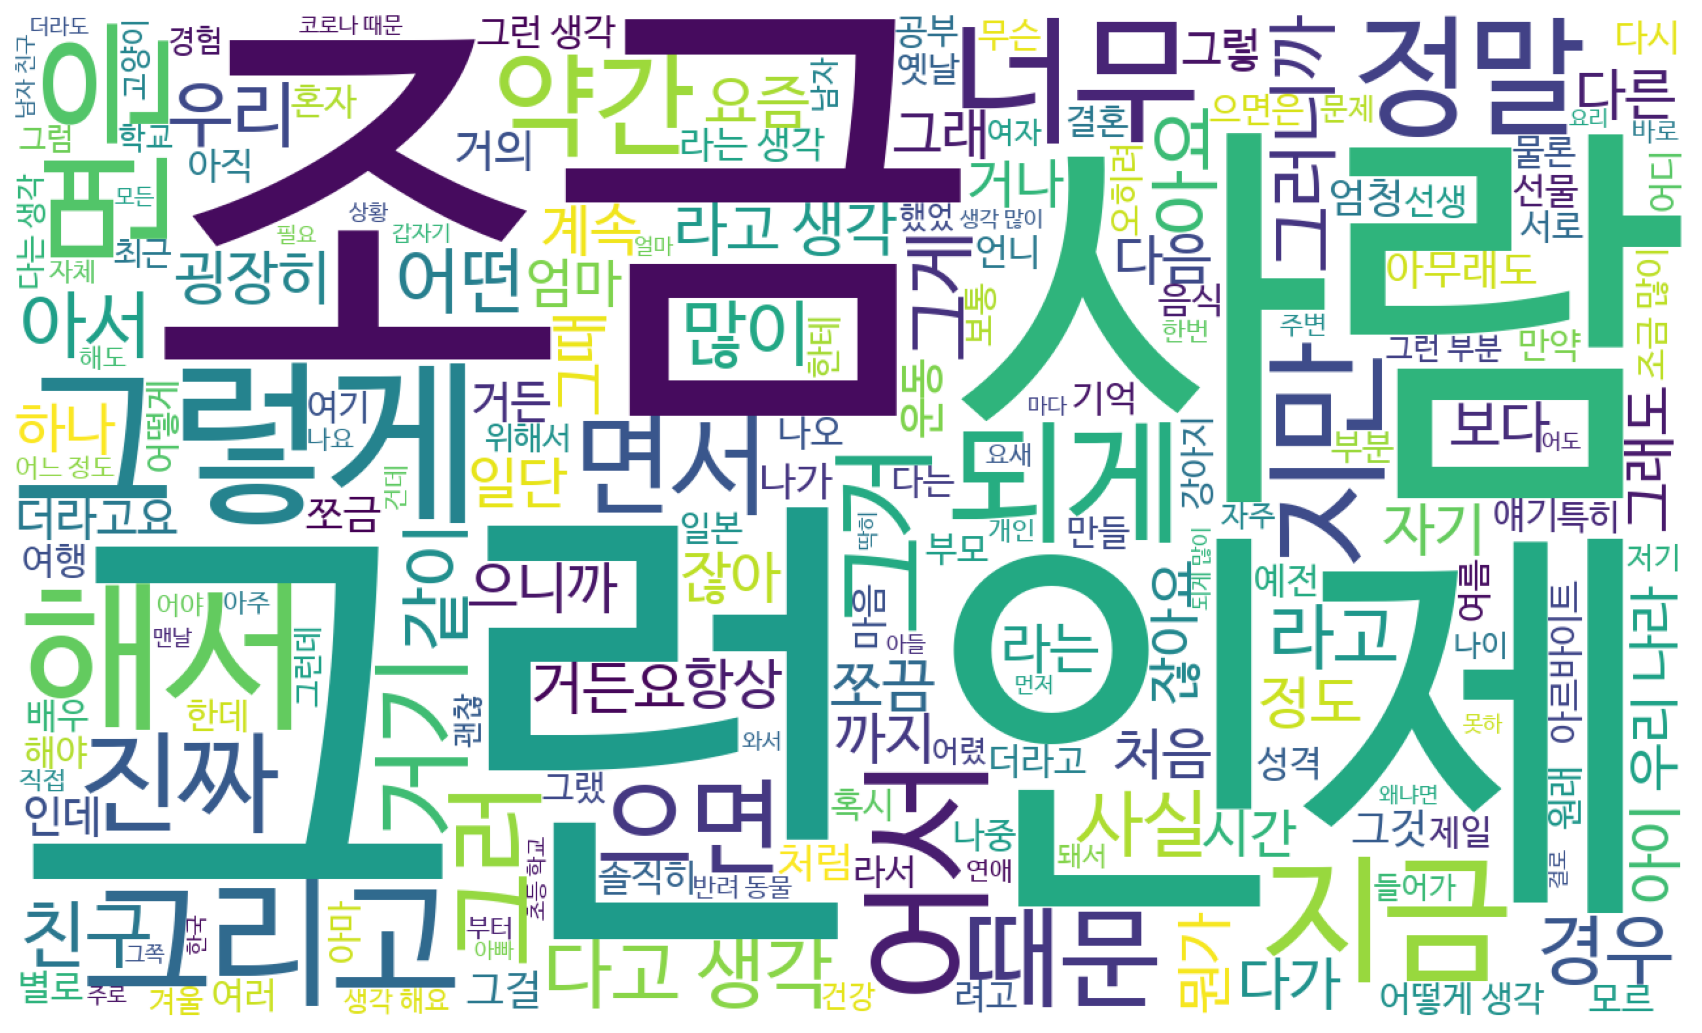

In [139]:
course_text = " ".join(df["transcript"])
displayWordCloud(course_text)